In [1]:
import pandas as pd
import numpy as np
import random as rnd
from termcolor import colored
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
%matplotlib inline

bold_start = '\033[1m'
underline_start = '\033[4m'
bu_end = '\033[0m'


In [2]:
train_df = pd.read_csv('death_prediction_synthetic.csv')

In [3]:
def col_to_num(df):
    col_to_num= {}
    k = 0
    for col in df.columns:
        col_to_num[col] = k
        k += 1
    return col_to_num

In [4]:
def high_correlation_values(cor):
    sorted_cor = cor.unstack()
    sorted_cor = sorted_cor.sort_values()
    sorted_cor = sorted_cor.loc[((sorted_cor > 0.5) | (sorted_cor < -0.5)) & (sorted_cor != 1)]
    print(sorted_cor[::2])

In [5]:
def plot_correlation(df, method='pearson', cor_return = False):
    cor = df.corr(method=method)
    plt.figure(figsize=(28,28))
    plt.title("The method used: " + method[0].upper() + method[1:], fontsize=25)
    sns.heatmap(np.abs(round(cor, 3)), annot=True, cmap='Greys')
    plt.show() 
    if cor_return:
        return cor

Reading the data and understading the types

In [6]:
des_df = {  'attName':[],
            'count':[],
            'mean':[],
            'std':[], 
            'min':[], 
            '25%':[], 
            '50%':[], 
            '75%':[], 
            'max':[]
            }
for att in train_df.columns:
    description = train_df[att].describe(include='all')
    des_df['attName'].append(att)
    for key in list(des_df.keys())[1:]:
        try:
            des_df[key].append(description[key])
        except:
            des_df[key].append(np.NaN)
des_df = pd.DataFrame(data=des_df)
des_df.to_csv("description.csv")
des_df.head()

,attName,count,mean,std,min,25%,50%,75%,max
0,age,12438.0,43.501126,4.802035,30.0,41.0,45.0,48.0,49.0
1,sex,12438.0,1.468805,0.499046,1.0,1.0,1.0,2.0,2.0
2,marital_status,12438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ses,12438.0,1.677279,0.763641,1.0,1.0,1.0,2.0,3.0
4,residence_cd,12438.0,1.062631,0.242307,1.0,1.0,1.0,1.0,2.0


In [7]:
numberOfPeople = train_df.shape[0]
totalDeath = train_df["dead_5y"].sum()

The following will justify why we choose our approach. In summary, according to the Central Bureau of Statistics the data we are dealing with have a large rate of sick (causes of death) people. 

We decided to use unsupervised learning to classify the risk groups. Unsupervised learning allows us to automatically identify patterns in the data and classify them into risk groups. This is a more efficient way of dealing with data that has a large rate of sick people, as it requires less manual intervention and will provide more accurate results.

In [8]:
old_death_population = {
    2018: (1770, 2229702),
    2017: (1780, 2191646),
    2016: (1798, 2150096),
    2015: (1697, 2110721),
    2014: (1733, 2070562),
    2013: (1694, 2030785),
    2012: (1699, 1990188),
    2011: (1704, 1952624),
    }
print(f'{"Year":<8s} | {"Death":<10s} | {"Population":<10s} | {"DeathRate":<10s}')
for year in old_death_population.keys():
    death_rate_s = round((old_death_population[year][0]/old_death_population[year][1])*100, 4)
    print(f'{year:<8} | {old_death_population[year][0]:<10} | {old_death_population[year][1]:<10} | {death_rate_s:<10}%')

print(bold_start + underline_start+  f'{"Data":<8} | {totalDeath:<10} | {numberOfPeople:<10} | {str(round(totalDeath/numberOfPeople*100, 4)):<10}%' + bu_end)


Year     | Death      | Population | DeathRate 
2018     | 1770       | 2229702    | 0.0794    %
2017     | 1780       | 2191646    | 0.0812    %
2016     | 1798       | 2150096    | 0.0836    %
2015     | 1697       | 2110721    | 0.0804    %
2014     | 1733       | 2070562    | 0.0837    %
2013     | 1694       | 2030785    | 0.0834    %
2012     | 1699       | 1990188    | 0.0854    %
2011     | 1704       | 1952624    | 0.0873    %
Data     | 197        | 12438      | 1.5839    %


The following section will be the data preparation, we'll preform data cleaning, transformation, selection etc. It's like putting together a puzzle; gathering the pieces, arranging them in the right order and ensuring no pieces are missing.

First we'll find the attributes contains NULL values.

In [9]:
nullContainAtt = dict()
print(f'{"Attribute":<14} {"Null Values":}  {"Null Rate":}')
for attName in train_df.columns:
    train_df[train_df == "NA"] = np.nan
    train_df[train_df == "NaN"] = np.nan
    numOfNulls = train_df[attName].isna().sum()
    if numOfNulls > 0:
        nullContainAtt[attName] = [numOfNulls, numOfNulls/numberOfPeople]
        print(f'{bold_start}{attName:<14} {numOfNulls:<10}{bu_end} {round(numOfNulls/numberOfPeople,2)*100:>10}')
train_df[train_df == "NA"] = np.nan
train_df[train_df == "NaN"] = np.nan

Attribute      Null Values  Null Rate
albumin        1463             12.0
alb24h         8918             72.0
ACR            1212             10.0
gravity_u      2530             20.0
nitrites_u     2520             20.0
leuko_u        2507             20.0
proteinuria    2506             20.0


In [10]:
def plot_null_features(df):
  d = df[['ACR','gravity_u','nitrites_u','leuko_u','proteinuria']]
  d.describe(include='all'), d.median()
  fig, axes = plt.subplots(nrows=5, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(8)
  j = 0
  for col in d.columns:
    d.hist(column=col, bins=20, grid=False, ax=axes[j, 0])
    d[col].plot.kde(ax=axes[j, 1])
    title = col
    fontSize = 10
    colour = 'black'
    axes[j, 0].set_title(title, fontsize=fontSize, color=colour)
    axes[j, 1].set_title(title, fontsize=fontSize, color=colour)
    j+=1
  print(pd.Series({col:d[col].unique() for col in d}))
  print(d.describe(include='all'))

ACR            [6.0, 3.87, 6.35, 5.0, 0.48, 30.0, 4.16, 3.14,...
gravity_u      [1.025, 1.021, 1.03, 1.017, 1.028, 1.02, nan, ...
nitrites_u                                  [0.0, nan, 1.0, 2.0]
leuko_u        [0.0, 1.0, nan, 75.0, 100.0, 25.0, 250.0, 500....
proteinuria                                      [0.0, nan, 1.0]
dtype: object
                ACR    gravity_u   nitrites_u      leuko_u  proteinuria
count  11226.000000  9908.000000  9918.000000  9931.000000  9932.000000
mean      38.829212     1.022250     0.037709    40.851576     0.050745
std      117.962082     0.008226     0.202310   120.788718     0.219488
min        0.000000     1.000000     0.000000     0.000000     0.000000
25%        3.870000     1.016000     0.000000     0.000000     0.000000
50%        7.000000     1.021000     0.000000     0.000000     0.000000
75%       21.000000     1.028000     0.000000     0.000000     0.000000
max     1494.570000     1.050000     2.000000   500.000000     1.000000


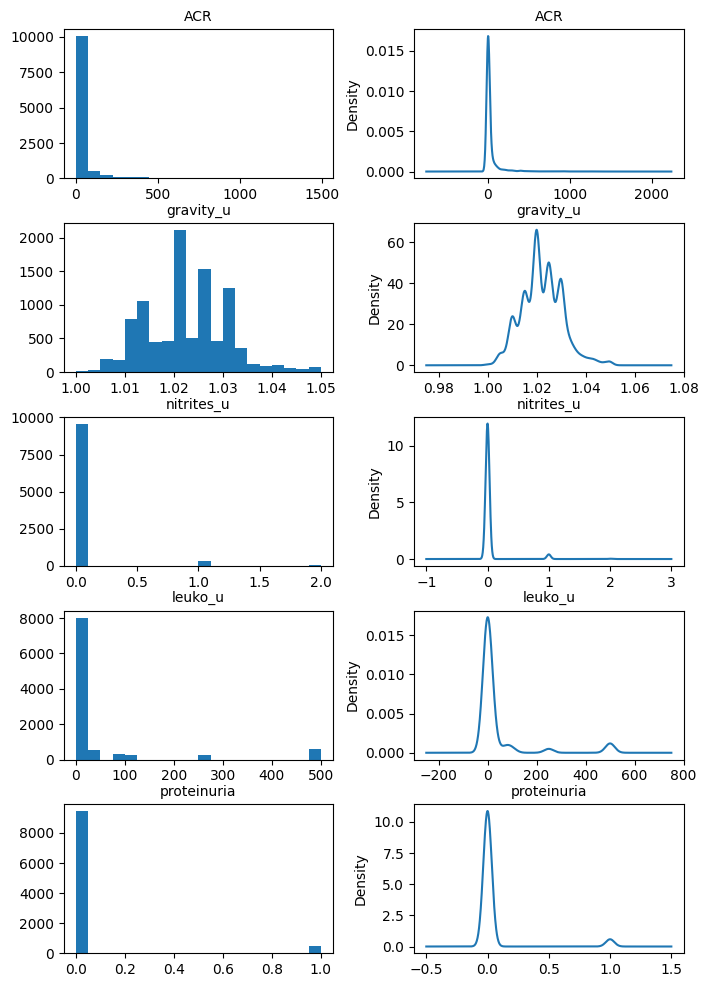

In [11]:
plot_null_features(train_df)

In [12]:
random_vals = pd.Series(np.abs(np.random.normal(size=1212)))
random_around_median = list(random_vals * train_df['ACR'].median())
acr_replacment = []
for i in train_df['ACR']:
    if math.isnan(i):
        acr_replacment.append(random_around_median.pop(0))
    else:
        acr_replacment.append(i)

train_df['ACR'] = pd.Series(acr_replacment)

In [13]:
# Categorize maybe?? "alb24h", "nitrites_u", "proteinuria", "leuko_u", 'gravity_u'
train_df['gravity_u'] = train_df['gravity_u'].fillna(method='ffill')

The description file helps to understand that cancer have no effect so we'll remove this attribute
albumin have 70%+ missing values
nitrites and protein in the urine is not a large death risk

In [14]:
train_df = train_df.drop(["cancer", "alb24h", "nitrites_u", "proteinuria", "leuko_u"], axis=1)
train_df.head()

,age,sex,marital_status,ses,residence_cd,residence,weigh,heigh,BMI,bp_sys,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
0,49,2,U,1,1,urban,84.0,160.0,32.79,116,...,1,0.12908,1,0,0,1,1,1,0,0
1,46,2,M,1,1,urban,67.0,152.0,29.38,113,...,1,0.08500,1,0,0,0,1,1,0,0
2,46,2,U,1,1,urban,62.4,148.0,28.31,133,...,1,0.10715,1,0,0,1,1,1,0,0
3,45,1,U,2,1,urban,73.9,166.0,26.85,100,...,1,0.10110,1,0,0,0,0,1,0,0
4,49,2,U,1,1,urban,53.0,161.0,20.45,110,...,1,0.03950,1,0,0,0,0,1,0,0


In [15]:
# Transform the sex feature to binary
train_df['sex'] = train_df['sex'] - 1
train_df['sex'].value_counts()

0    6607
1    5831
Name: sex, dtype: int64

In [16]:
train_df.select_dtypes(exclude=['int64', 'float64'])

,marital_status,residence,bp_cat,smoking_status
0,U,urban,Normal,non_smoker
1,M,urban,Normal,non_smoker
2,U,urban,Pre-HTN,non_smoker
3,U,urban,Normal,current_smoker
4,U,urban,Normal,non_smoker
...,...,...,...,...
12433,U,urban,Pre-HTN,non_smoker
12434,M,urban,Normal,non_smoker
12435,U,urban,Normal,current_smoker
12436,M,urban,Normal,non_smoker


In [17]:
train_df['residence'].value_counts(), train_df['residence_cd'].value_counts()

(urban    11659
 rural      779
 Name: residence, dtype: int64,
 1    11659
 2      779
 Name: residence_cd, dtype: int64)

We can drop the string residence column since the residence and residence_cd columns both contain the same values.

In [18]:
train_df = train_df.drop(["residence"], axis=1)

נשנה את סטטוס הנישואים לבינארי, נשוי/ה (1) או לא (0), בהתאם למה שעשינו לפני

In [19]:
train_df['marital_status'] = train_df['marital_status'].map({"U" : 0, "M": 1})
train_df['smoking_status'].value_counts(), train_df['smoking'].value_counts()

(non_smoker        7806
 current_smoker    3287
 past_smoker       1345
 Name: smoking_status, dtype: int64,
 1    7806
 3    3287
 2    1345
 Name: smoking, dtype: int64)

In [20]:
# Its quite easy to see that the smoking and smoking status are the same, we'll drop the smoking status since it's string
train_df = train_df.drop(columns='smoking_status', axis=1)

נבדוק קורלציה בין ביפי_קאט לעמודות השונות

In [21]:
train_df['bp_cat'] = train_df['bp_cat'].map({"Normal": 0, "Pre-HTN": 1, "HTN-G1": 2, "HTN-G2": 3, "HTN-G3": 4}).astype(int)

In [22]:
train_df.loc[(train_df['bp_cat'] == 1)]

,age,sex,marital_status,ses,residence_cd,weigh,heigh,BMI,bp_sys,bp_dias,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
2,46,1,0,1,1,62.40,148.0,28.31,133,87,...,1,0.10715,1,0,0,1,1,1,0,0
9,44,1,1,1,1,72.00,164.0,26.77,137,76,...,2,0.09586,1,0,0,0,0,0,0,0
10,33,0,1,1,1,112.00,185.0,32.72,130,80,...,1,0.03946,1,0,0,1,1,1,0,0
17,49,1,1,2,1,78.00,157.5,31.24,130,89,...,1,0.11276,1,0,0,1,1,1,1,0
19,45,0,0,2,1,83.00,169.0,29.06,117,86,...,1,0.08349,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12417,49,0,1,1,1,78.00,175.0,25.60,137,86,...,3,0.37036,1,0,0,1,1,1,1,0
12425,44,1,1,2,1,98.85,167.0,35.14,130,80,...,1,0.11030,1,0,0,0,0,1,0,0
12429,48,1,0,2,1,80.00,161.0,30.86,130,75,...,3,0.16726,1,0,0,0,0,1,1,0
12432,48,0,1,1,2,94.00,170.0,32.53,126,85,...,1,0.41173,1,0,0,1,1,1,0,0


In [23]:
max(train_df['bp_sys']), max(train_df['bp_dias'])

(200, 135)

The first table shows the countnious features correlation, we'll deal the categorical features later.

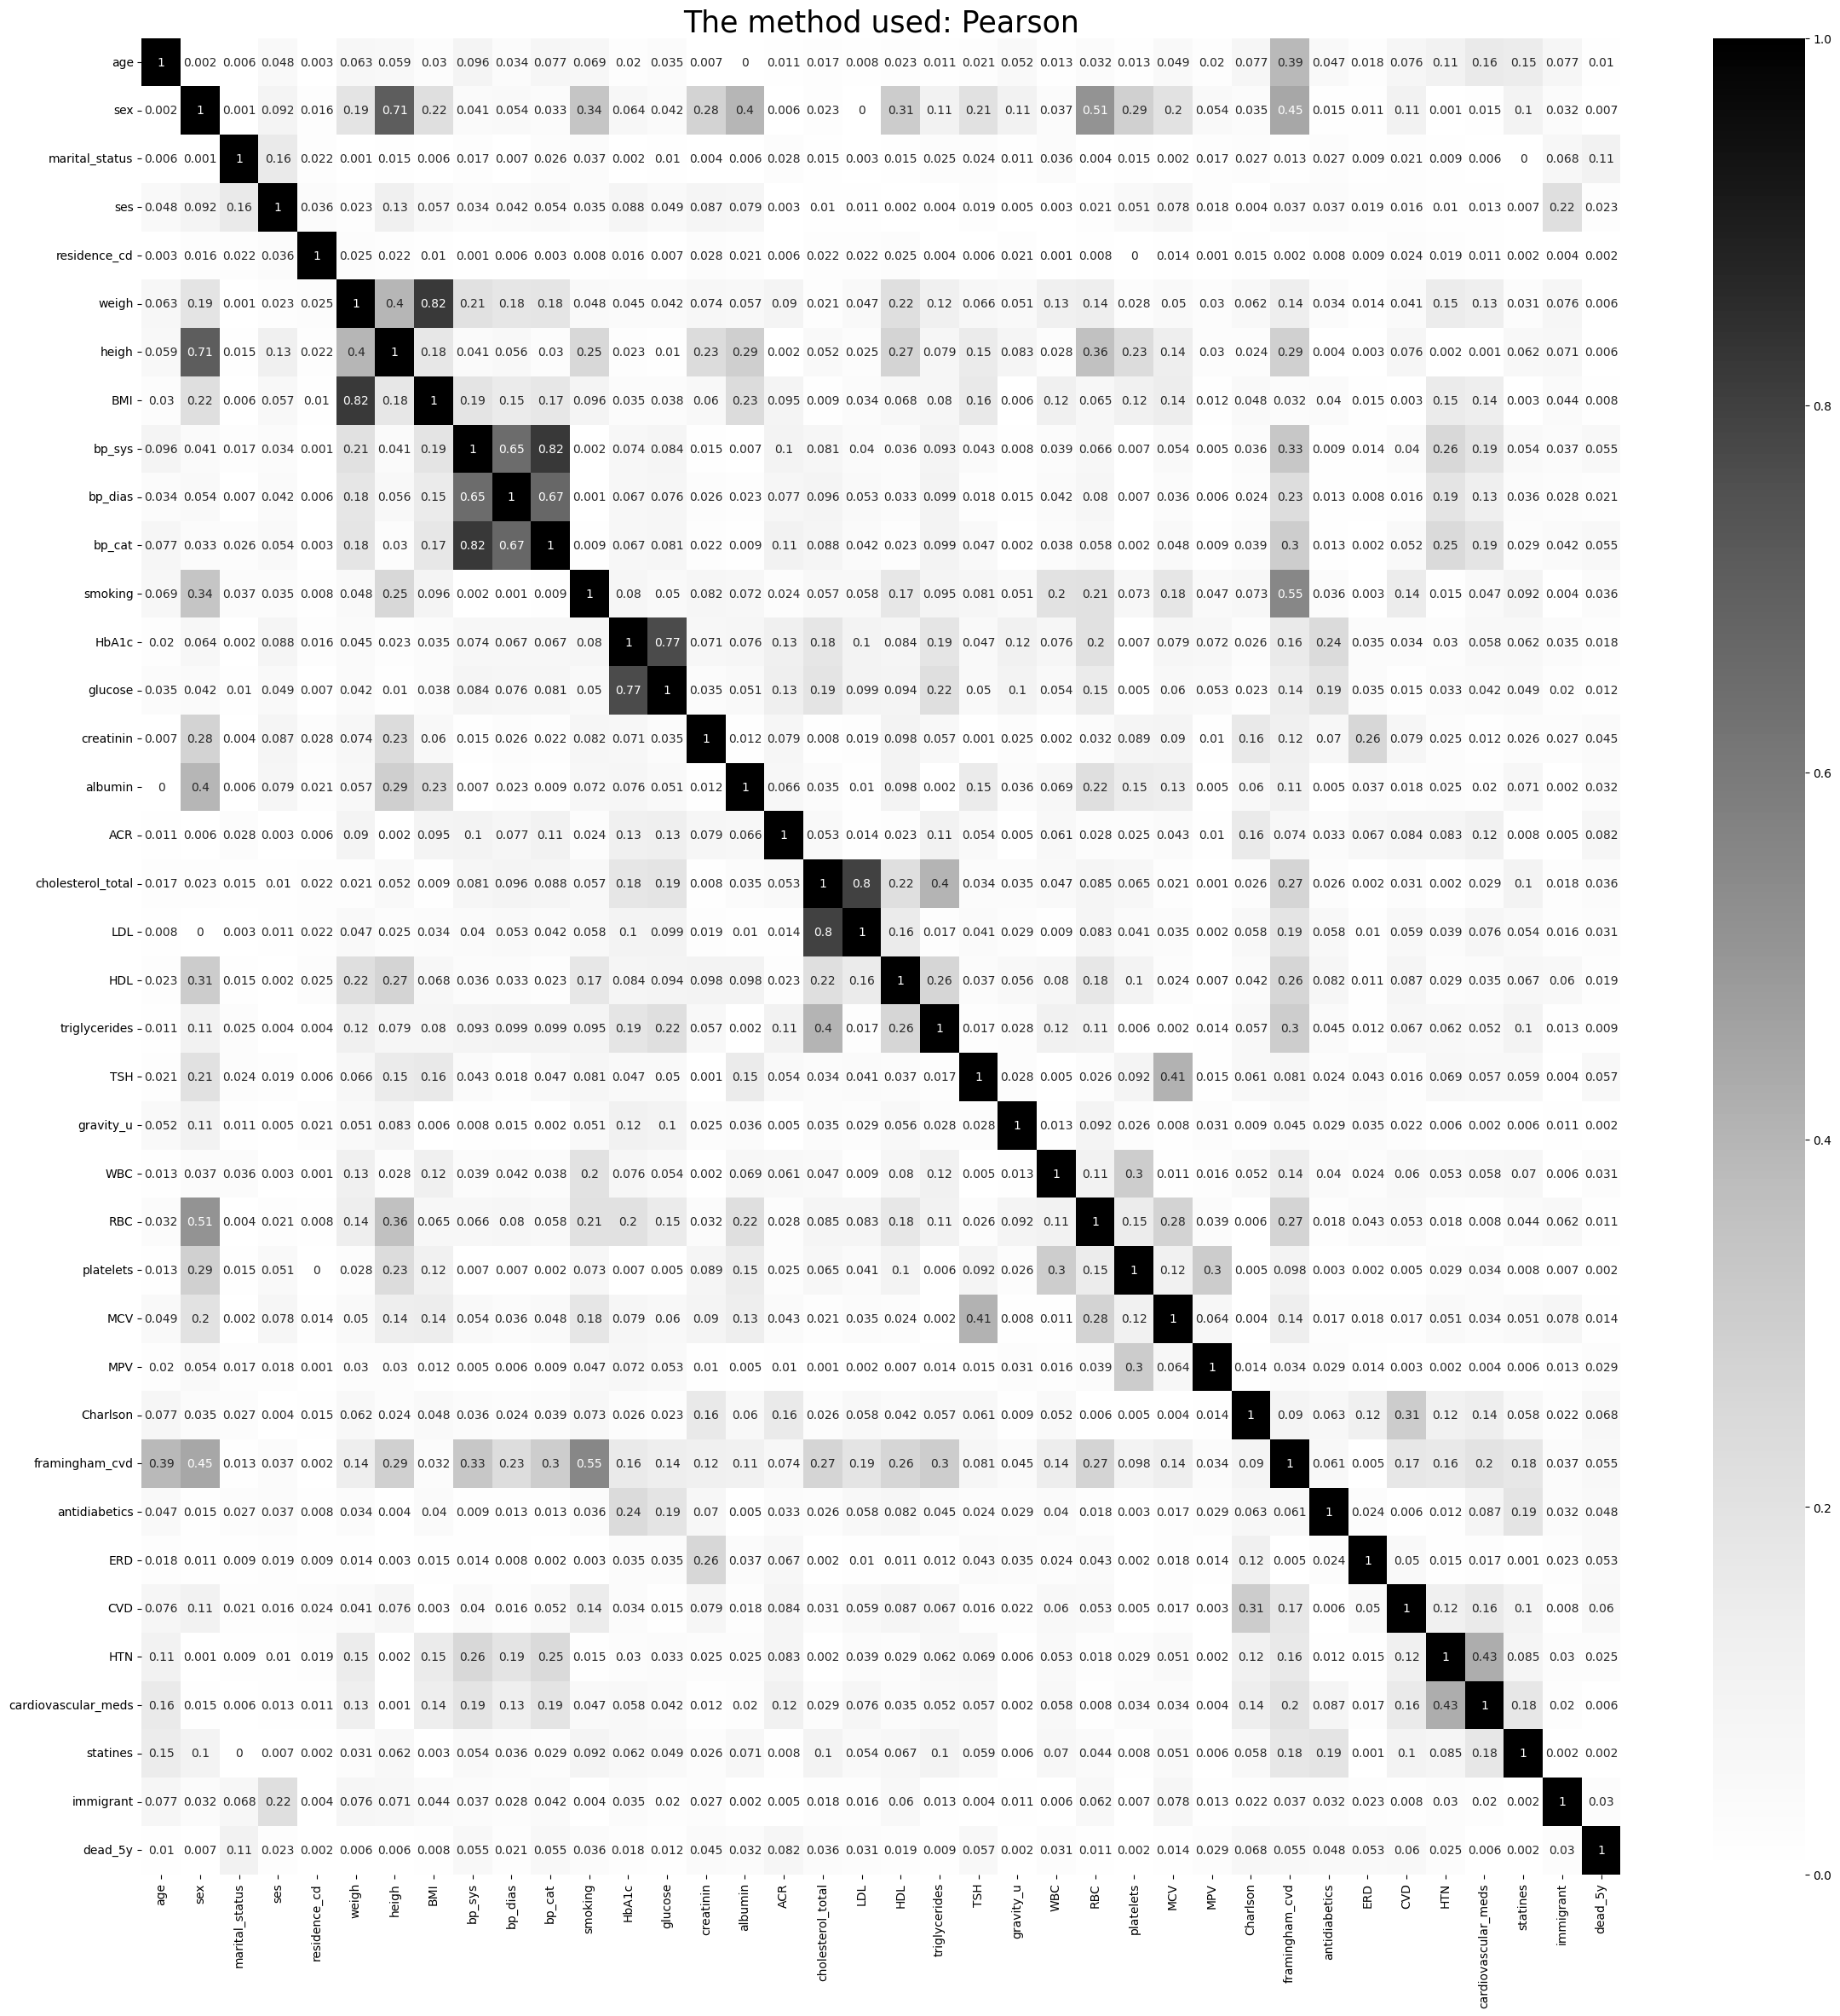

In [24]:
plot_correlation(train_df)

#In the following part we'll deal with feature selection in order to avoid multicollinearity 

High correlation between bp_sys and bp_dias to bp cat so we think that bp_cat maps those two features well

In [25]:
train_df.to_csv('new_dataset.csv')

In [26]:

bp_pca = train_df[['bp_sys', 'bp_dias', 'bp_cat']]
pca = PCA(n_components=2)
pca.fit(bp_pca)
data_pca = pca.transform(bp_pca)
col_dict = col_to_num(train_df)
index = min(col_dict['bp_sys'],col_dict['bp_cat'], col_dict['bp_dias'])
train_df.insert(index, "new_bp_pca_1", 0)
train_df.insert(index+1, "new_bp_pca_2", 0)
train_df['new_bp_pca_1'] = data_pca[:, 0]
train_df['new_bp_pca_2'] = data_pca[:, 1]


המטרה בשילוב הפיצרים היא בשיפור הקורלציות והורדת המימדים כך שננסה לבטא את קאט באמצעות העמודות האחרות, אכן יש שיפור בקורלציות (להוסיף באיזה שיפור)

In [27]:
train_df.to_csv('new_dataset.csv')
# train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat'], axis=1)

In [28]:
train_df['albumin'].describe() # we know that mean is not affected by noise

count    10975.000000
mean         4.327445
std          0.329294
min          2.500000
25%          4.100000
50%          4.300000
75%          4.530000
max          5.700000
Name: albumin, dtype: float64

In [29]:
train_df['albumin'] = train_df['albumin'].fillna(train_df['albumin'].mean()) # מלאים את החציוני באוכלוסיה כדי לשמור על העמודה ולהשתמש בה

לא סומכים על מדד הביאמי שניתן לנו, ניתן לראות שבחישוב מקומי הגדלנו את הקורלציות.

In [30]:
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')
train_df['BMI'] = train_df['weigh'] / (train_df['heigh'] ** 2)
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')

BMI <-> weigh 0.817, BMI <-> heigh -0.1784
BMI <-> weigh 0.8226, BMI <-> heigh -0.1803


נזרוק את עמודות המשקל והגובה כדי להוריד מימדים ונשתמש בביאמי

In [31]:
# train_df = train_df.drop(['weigh', 'heigh'], axis=1)

In [32]:
train_df.to_csv('new_dataset.csv')

(<AxesSubplot: xlabel='LDL', ylabel='Density'>,
 <AxesSubplot: xlabel='cholesterol_total', ylabel='Density'>)

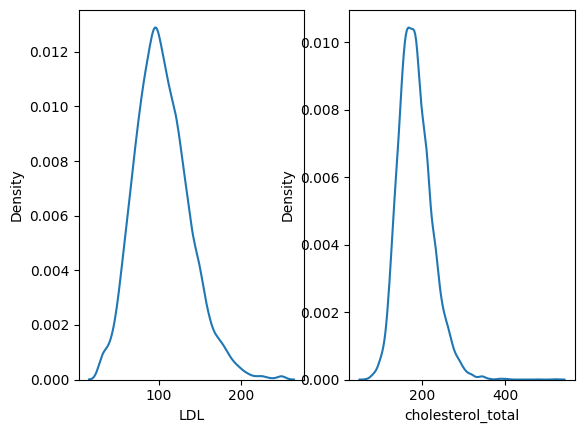

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
sns.kdeplot(train_df['LDL'], ax=ax), sns.kdeplot(train_df['cholesterol_total'], ax=ax1)

In [34]:
cor = train_df.corr()
cor['cholesterol_total'].loc[(np.abs(cor['cholesterol_total']) > 0.5) & (cor['cholesterol_total'] != 1)]

LDL    0.795632
Name: cholesterol_total, dtype: float64

In [35]:
# We diceded to drop the cholesterol_total feature because it's high correlation
# train_df = train_df.drop(columns='cholesterol_total', axis=1)

In [36]:
# Sex and smoking are categorical feature so we'll test it again using spearman correlation
print(train_df['HbA1c'].describe(), train_df['glucose'].describe())

count    12438.000000
mean         7.623666
std          1.867250
min          4.000000
25%          6.300000
50%          7.100000
75%          8.500000
max         16.800000
Name: HbA1c, dtype: float64 count    12438.000000
mean       153.757276
std         64.724782
min         40.000000
25%        110.000000
50%        134.000000
75%        177.000000
max        883.000000
Name: glucose, dtype: float64


In [37]:
train_df['mult_glu_HbA'] = train_df['HbA1c'] * train_df['glucose']

In [38]:
# So the multiplication of glucose and HbA1c works well, we can drop those features and stay with the new feature
# train_df = train_df.drop(["glucose", "HbA1c"], axis=1)

In [39]:
train_df['creatinin'].describe()

count    12438.000000
mean         0.751235
std          0.428875
min          0.110000
25%          0.600000
50%          0.710000
75%          0.840000
max         11.150000
Name: creatinin, dtype: float64

In [40]:
sex_pca = TSNE(2)
p =  sex_pca.fit_transform(train_df[['sex', 'RBC', 'creatinin']])
index = min(col_dict['RBC'], col_dict['creatinin'])
train_df.insert(index, 'new_tnse_1', 0)
train_df.insert(index+1, 'new_tnse_2', 0)
train_df['new_tnse_1'] = p[:, 0]
train_df['new_tnse_2'] = p[:, 1]

we'll drop the smoking feature, the framingham cvd rate contributes more to know who will die.

In [41]:
train_df.to_csv('new_dataset.csv')

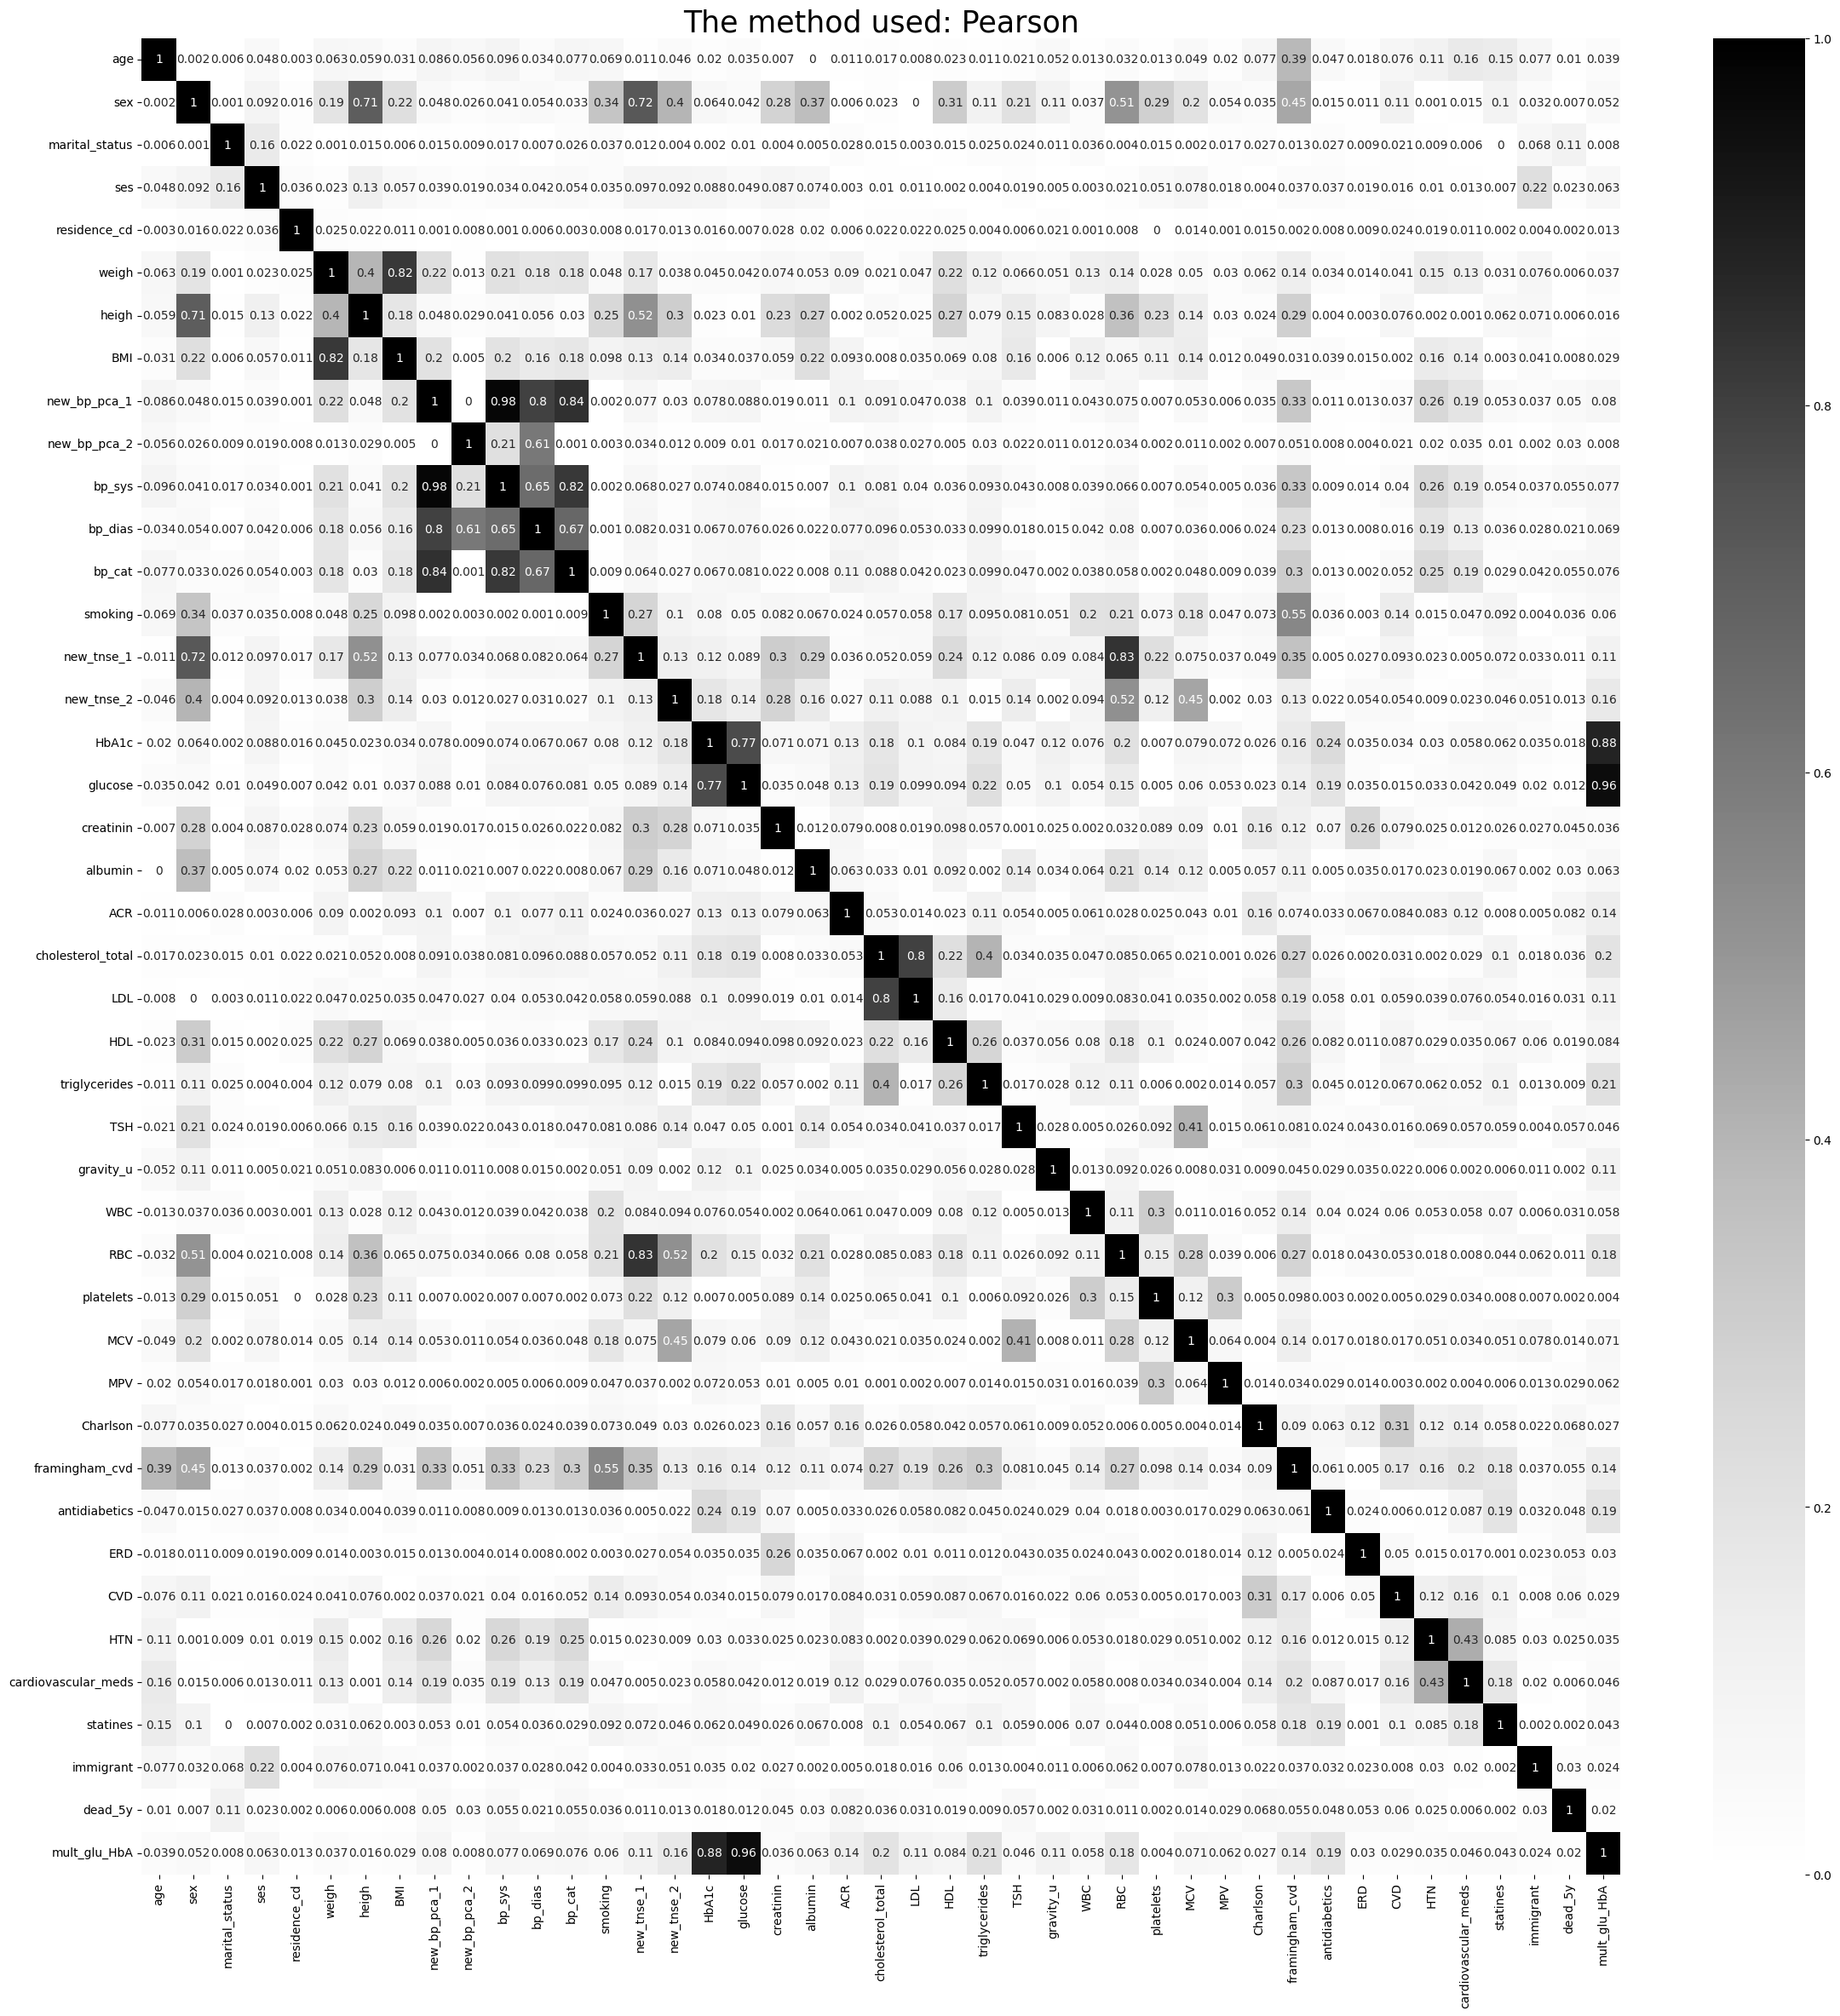

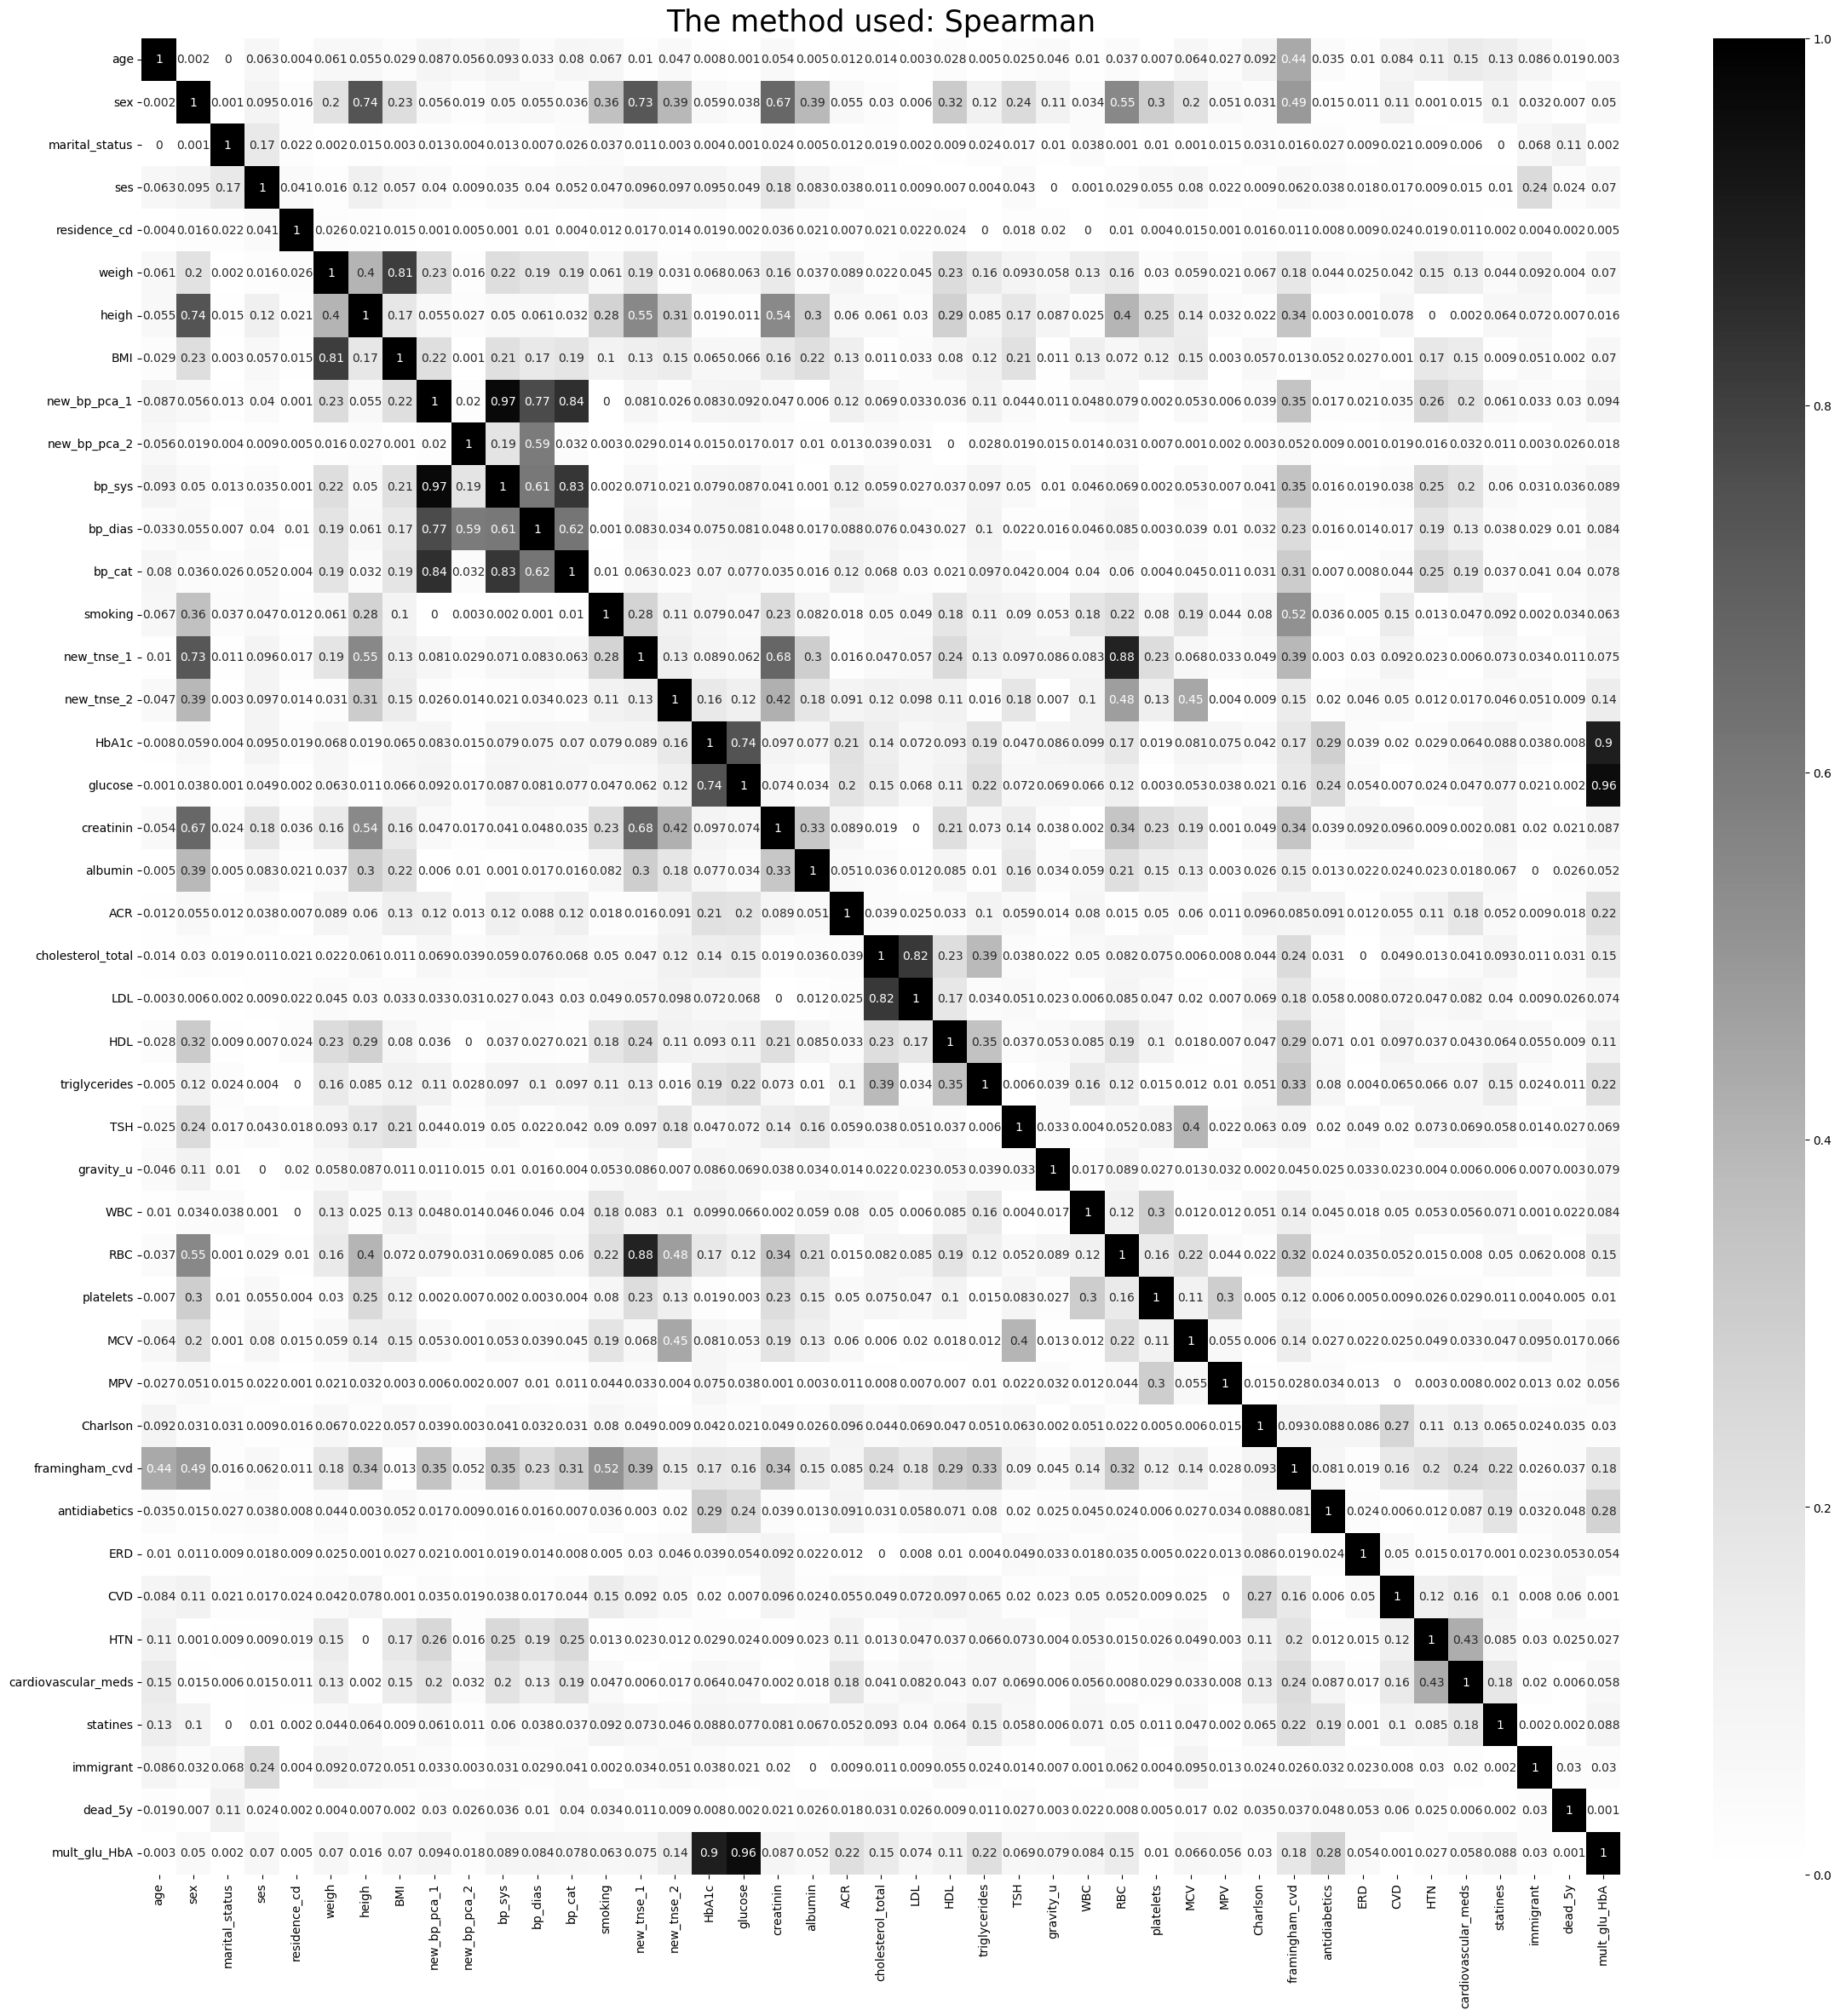

(None, None)

In [42]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

In [43]:
train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat', 'weigh', 'heigh',
'cholesterol_total', 'HbA1c', 'glucose', 'sex', 'RBC', 'creatinin'], axis=1)

In [44]:
train_df['framingham_cvd'].loc[(train_df['framingham_cvd'] > 0.13) &(train_df['smoking'] == 1) & (train_df['dead_5y'] == 1)].count()

30

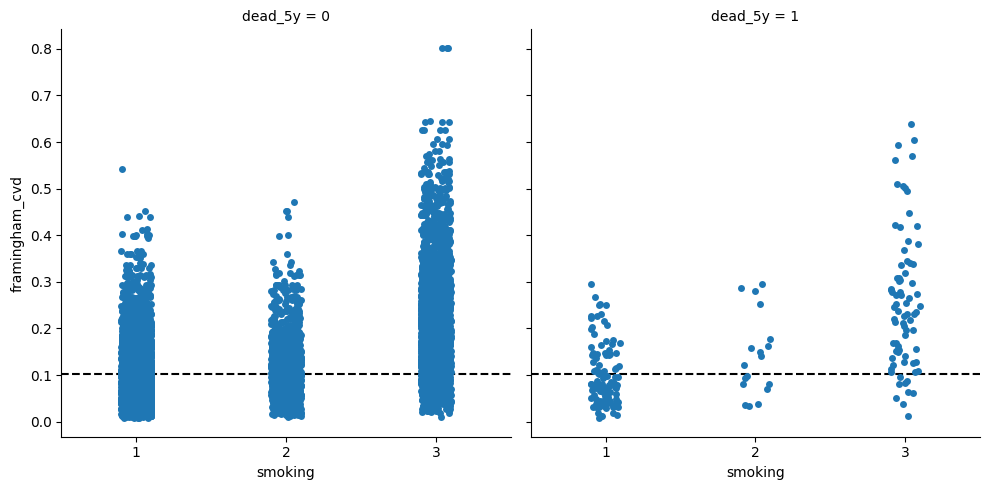

In [45]:
data = train_df[['framingham_cvd', 'smoking','dead_5y']]
f = sns.catplot(data=data, x='smoking', y='framingham_cvd', col='dead_5y')
f.axes[0][0].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')
f.axes[0][1].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')

In [46]:
train_df = train_df.drop(['framingham_cvd'], axis=1)
train_df.shape

(12438, 31)

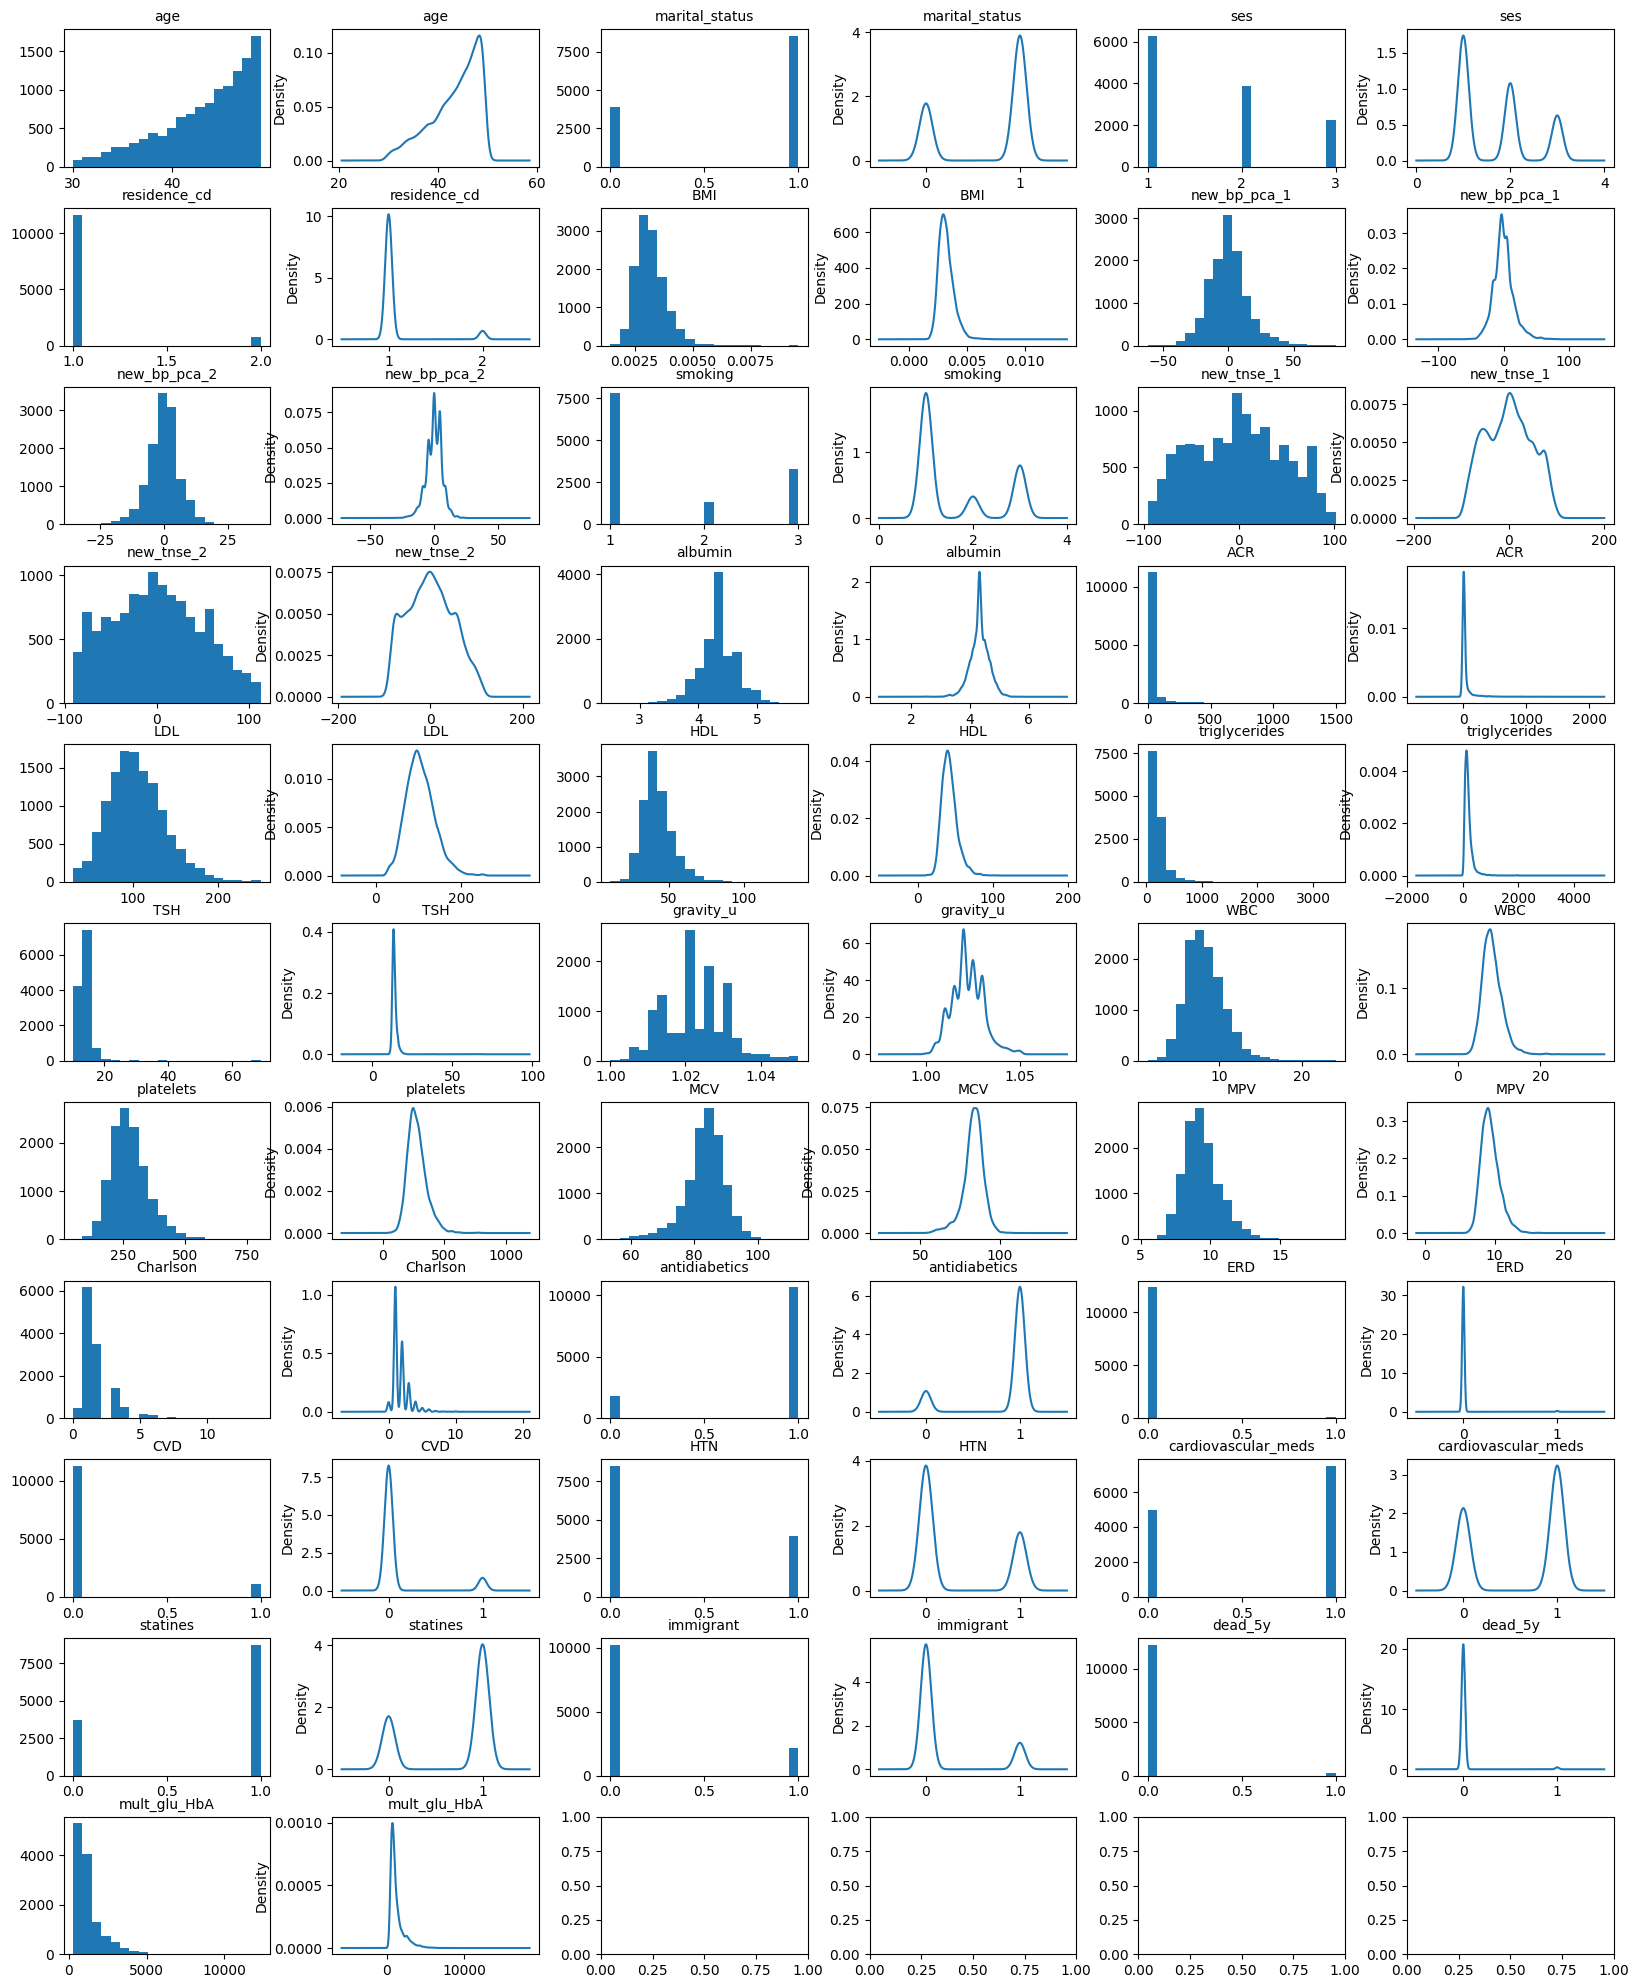

In [47]:
fig, axes = plt.subplots(nrows=11, ncols=6) 
fig.set_figheight(25)
fig.set_figwidth(20)
i = 0
j = 0
for col in train_df.columns:
  train_df.hist(column=col, bins=20, grid=False, ax=axes[i, j%3*2])
  train_df[col].plot.kde(ax=axes[i, j%3*2+1])
  title = col
  fontSize = 10
  colour = 'black'
  axes[i, j%3*2].set_title(title, fontsize=fontSize, color=colour)
  axes[i, j%3*2+1].set_title(title, fontsize=fontSize, color=colour)
  j += 1 
  if j % 3 == 0:
     i += 1

In [48]:
train_df.describe()

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,Charlson,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y,mult_glu_HbA
count,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,1.243800e+04,1.243800e+04,12438.000000,12438.000000,12438.000000,...,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000
mean,43.501126,0.686364,1.677279,1.062631,0.003187,4.167969e-15,7.632136e-16,1.636678,-0.311763,0.299436,...,1.755427,0.857694,0.006593,0.092057,0.318058,0.602669,0.702203,0.174867,0.015839,1265.016736
std,4.802035,0.463989,0.763641,0.242307,0.000649,1.509746e+01,6.121911e+00,0.871735,47.504292,49.172028,...,1.218773,0.349378,0.080931,0.289117,0.465741,0.489365,0.457308,0.379869,0.124856,891.027097
min,30.000000,0.000000,1.000000,1.000000,0.001453,-6.145859e+01,-3.537448e+01,1.000000,-95.726631,-90.907127,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,265.500000
25%,41.000000,0.000000,1.000000,1.000000,0.002738,-8.344269e+00,-4.196398e+00,1.000000,-39.934968,-38.293388,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,710.475000
50%,45.000000,1.000000,1.000000,1.000000,0.003101,-1.298131e+00,2.161271e-01,1.000000,-0.088472,-1.003490,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,950.400000
75%,48.000000,1.000000,2.000000,1.000000,0.003538,6.799706e+00,4.407531e+00,3.000000,35.050464,36.889856,...,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1464.000000
max,49.000000,1.000000,3.000000,2.000000,0.009555,8.209091e+01,3.769933e+01,3.000000,101.311104,113.139496,...,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12362.000000


NORMALIZE - (if it's distributaion looks like normal its in the normal list, otherwise in the mixed list)

In [49]:
normal_dist_lst = ['BMI', 'albumin', 'LDL', 'HDL', 'gravity_u', 'WBC', 'platelets', 'MCV', 'MPV', 'new_bp_pca_1', 'new_bp_pca_2', 'new_tnse_1', 'new_tnse_2']
mixed_dist_lst = ['age', 'ACR', 'TSH', 'Charlson', 'mult_glu_HbA']
min_max = pp.MinMaxScaler()
train_df[normal_dist_lst] = min_max.fit_transform(train_df[normal_dist_lst])
normalize = pp.Normalizer()
train_df[mixed_dist_lst] = normalize.fit_transform(train_df[mixed_dist_lst])

In [50]:
from imblearn.over_sampling import SMOTENC
from sklearn.cluster import MiniBatchKMeans

y = train_df['dead_5y']
x = train_df.copy()
x = x.drop('dead_5y', axis=1)
col_num_lst = col_to_num(x)
cat_list = list(train_df.columns)
for colname in train_df.columns:
    if colname in normal_dist_lst or colname in mixed_dist_lst or colname == 'dead_5y':
        cat_list.pop(cat_list.index(colname))
    else:
        cat_list[cat_list.index(colname)] = col_num_lst[colname]
cat_list

sm = SMOTENC(cat_list)
X_res, y_res = sm.fit_resample(x, y)
# X_res, y_res = x, y
X_res.describe()

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,MPV,Charlson,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,mult_glu_HbA
count,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,...,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000
mean,0.046686,0.405890,1.711829,1.031819,0.217470,0.445443,0.475742,1.675190,0.496266,0.457189,...,0.296815,0.002087,0.876685,0.006045,0.084756,0.330447,0.648762,0.803162,0.128911,0.989607
std,0.021804,0.491073,0.784275,0.175522,0.085390,0.113458,0.082401,0.913548,0.220965,0.253711,...,0.097287,0.002110,0.328805,0.077517,0.278524,0.470384,0.477367,0.397617,0.335108,0.046309
min,0.003695,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348687
25%,0.029716,0.000000,1.000000,1.000000,0.156850,0.374492,0.426666,1.000000,0.327036,0.254236,...,0.227149,0.000857,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.996752
50%,0.045167,0.000000,2.000000,1.000000,0.206377,0.431373,0.483076,1.000000,0.496111,0.440170,...,0.282409,0.001435,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.998308
75%,0.061395,1.000000,2.000000,1.000000,0.264844,0.500065,0.534563,3.000000,0.643879,0.640885,...,0.355556,0.002583,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.999193
max,0.177681,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,0.028612,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999991


In [51]:
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, train_size=0.8)


In [52]:
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# kmeans = KMeans(n_clusters=3, verbose=0)
# clusters = kmeans.fit_predict(x_train, y_train)
kmeans = BisectingKMeans(n_clusters=3, verbose=0)
clusters = kmeans.fit_predict(x_train, y_train)
test_clusterd = kmeans.predict(x_test)


In [53]:
test_clusterd_df = x_test
test_clusterd_df['class'] = test_clusterd*10+1
test_clusterd_df['dead_5y'] = y_test
clusterd_df = x_train
clusterd_df['class'] = clusters*10+1
clusterd_df['dead_5y'] = y_train
clusterd_df.head()

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,mult_glu_HbA,class,dead_5y
3315,0.031072,1,1,1,0.249574,0.413760,0.571588,1,0.629003,0.639854,...,1,0,0,1,0,0,0,0.999484,21,0
1044,0.014635,1,2,1,0.263049,0.462884,0.520100,1,0.297760,0.306718,...,1,0,0,0,1,1,0,0.970351,21,0
15356,0.052913,0,1,1,0.224102,0.273977,0.499453,3,0.481011,0.540009,...,1,0,1,0,1,1,0,0.998144,21,1
7497,0.057389,0,3,1,0.280127,0.497979,0.297948,3,0.716031,0.580700,...,1,0,0,1,1,1,0,0.998191,11,0
50,0.010694,1,1,1,0.257360,0.427697,0.448434,1,0.474533,0.090173,...,1,0,0,1,0,0,0,0.990886,21,0


In [54]:
def print_death_rate(df, class_num):
    class_2_death = df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 1)].count()
    class_2_live = df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 0)].count()
    class_2_total = df['age'].loc[(df['class'] == class_num)].count()
    print("Class:", class_num)
    print(f"Dath rate: {np.round(class_2_death/class_2_total,4)}, Total: {class_2_total}, Alive: {class_2_live}, Dead: {class_2_death}")

In [55]:
print_death_rate(clusterd_df, 0)
print_death_rate(clusterd_df, 1)
print_death_rate(clusterd_df, 2)

Class: 0
Dath rate: nan, Total: 0, Alive: 0, Dead: 0
Class: 1
Dath rate: 0.4194, Total: 93, Alive: 54, Dead: 39
Class: 2
Dath rate: nan, Total: 0, Alive: 0, Dead: 0


C:\Users\talro\AppData\Local\Temp\ipykernel_34392\2251674651.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Dath rate: {np.round(class_2_death/class_2_total,4)}, Total: {class_2_total}, Alive: {class_2_live}, Dead: {class_2_death}")


In [56]:
print_death_rate(test_clusterd_df, 0)
print_death_rate(test_clusterd_df, 1)
print_death_rate(test_clusterd_df, 2)

Class: 0
Dath rate: nan, Total: 0, Alive: 0, Dead: 0
Class: 1
Dath rate: 0.5652, Total: 23, Alive: 10, Dead: 13
Class: 2
Dath rate: nan, Total: 0, Alive: 0, Dead: 0


C:\Users\talro\AppData\Local\Temp\ipykernel_34392\2251674651.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Dath rate: {np.round(class_2_death/class_2_total,4)}, Total: {class_2_total}, Alive: {class_2_live}, Dead: {class_2_death}")


In [57]:
from lazypredict.Supervised import LazyClassifier, LazyRegressor
x_train, x_test, y_train, y_test = train_test_split(test_clusterd_df.drop('dead_5y', axis=1), test_clusterd_df['dead_5y'], test_size=0.2, train_size=0.8)
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

models

100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.96,0.96,0.96,0.96,0.21
XGBClassifier,0.96,0.96,0.96,0.96,1.33
RandomForestClassifier,0.95,0.95,0.95,0.95,1.61
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.37
SVC,0.92,0.92,0.92,0.92,0.55
BaggingClassifier,0.92,0.92,0.92,0.92,0.81
LabelPropagation,0.90,0.90,0.90,0.90,0.93
LabelSpreading,0.90,0.90,0.90,0.90,1.21
KNeighborsClassifier,0.87,0.87,0.87,0.87,0.06


In [121]:
reg = LazyRegressor(ignore_warnings=True, custom_metric=None)
models1,predictions1= reg.fit(x_train, x_test, y_train, y_test)

 64%|██████▍   | 27/42 [00:28<00:09,  1.55it/s]

: 

: 

In [ ]:
def model_accuracy(model, X_train, Y_train, X_test, Y_train):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc_model = round(model.score(X_train, Y_train) * 100, 2)
    return acc_model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier